# Transformer designing from scratch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=5000):
    super().__init__()

    # calculate positional encoding
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # max_len X 1
    # a = exp(lna)
    wk = torch.exp(
        torch.arange(0, d_model, 2).float() * (
            -torch.log(torch.tensor(10000.0)) / d_model
        )
    )
    # odd numbers: i = 2k
    pe[:, 0::2] = torch.sin(wk * position)
    # even numbers: i = 2k+1
    pe[:, 1::2] = torch.cos(wk * position)
    pe = pe.unsqueeze(0) # 1 X max_len X 1
    # DO NOT train this parameter
    self.register_buffer("pe", pe)

  def forward(self, X):
    X = X + self.pe[:, :X.size(1)]
    return X

In [ ]:
d_model = 512
max_len = 100

pos_encoder = PositionalEncoding(d_model, max_len)
input_sequence = torch.randn(5, max_len, d_model)
input_sequence = pos_encoder(input_sequence)
print("The positional encoding of the input sequence: ", input_sequence)
print(input_sequence.shape)

The positional encoding of the input sequence:  tensor([[[ 0.1706,  0.9645, -0.5309,  ...,  3.0374, -0.6587,  2.2385],
         [ 2.2107,  1.0045,  1.9371,  ...,  0.2144, -0.2195,  0.2174],
         [ 1.6376,  1.0803,  1.4062,  ...,  0.9825, -1.3147,  0.3080],
         ...,
         [-0.8048, -2.1817, -1.0171,  ...,  1.0361, -0.3386, -0.5037],
         [-0.8525, -0.1998,  0.2743,  ...,  0.6643,  0.6096,  2.1666],
         [-0.3101,  1.2173,  0.4512,  ...,  1.2000,  1.0078,  2.5805]],

        [[ 1.3590,  0.3813, -1.2305,  ...,  0.2203,  0.2462,  0.4577],
         [ 0.1069, -0.1687,  1.0890,  ...,  0.6959, -1.3970,  1.1105],
         [ 2.0439, -1.7396,  1.8060,  ...,  2.6375, -0.3121, -0.3506],
         ...,
         [ 0.1685, -0.9148, -0.8696,  ..., -0.7960, -0.0749,  0.9883],
         [ 0.8914, -0.7999,  1.4097,  ...,  1.2493, -0.8446, -1.1530],
         [-2.0633, -0.2735,  1.4708,  ...,  1.4191,  0.6064,  1.2878]],

        [[-0.8239,  1.4881,  0.0084,  ...,  0.0330, -0.2782,  1.5723

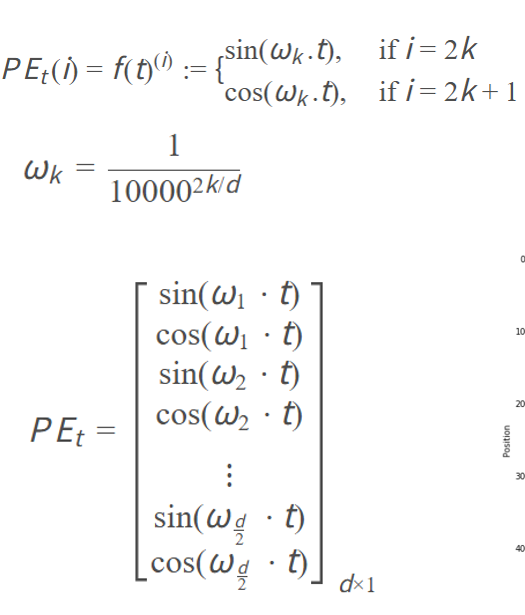

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super().__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    assert d_model % num_heads == 0
    self.depth = d_model // num_heads
    # QKV
    self.Q_linear = nn.Linear(d_model, d_model)
    self.K_linear = nn.Linear(d_model, d_model)
    self.V_linear = nn.Linear(d_model, d_model)
    # output the linear mapping
    self.output_linear = nn.Linear(d_model, d_model)

  def split_head(self, X):
    batch_size, seq_length, d_model = X.size()
    return X.view(
        batch_size, seq_length, self.num_heads, self.depth
    ).transpose(1, 2)

  def forward(self, Q, K, V, mask=None):
    # linear mapping
    Q = self.Q_linear(Q)
    K = self.K_linear(K)
    V = self.V_linear(V)

    # split heads
    Q = self.split_head(Q)
    K = self.split_head(K)
    V = self.split_head(V)

    # Scaled dot_product attention
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.depth)

    # if mask
    if mask is not None:
      scores = scores.masked_fill(mask==0, -1e9)

    attention_weights = torch.softmax(scores, dim=-1)
    attention_output = torch.matmul(attention_weights, V)

    # merge heads
    batch_size, _, seq_length, d_k = attention_output.size()
    attention_output = attention_output.transpose(1, 2).contiguous().view(
        batch_size, seq_length, self.d_model
    )

    # linear mapping
    attention_output = self.output_linear(attention_output)
    return attention_output

In [ ]:
num_heads = 8

multihead_attn = MultiHeadAttention(d_model, num_heads)
input_sequence = torch.randn(5, max_len, d_model)
attention_output = multihead_attn(input_sequence, input_sequence, input_sequence)
print("attention_output shape: ", attention_output.shape)
print(attention_output)

attention_output shape:  torch.Size([5, 100, 512])
tensor([[[ 0.0171,  0.0154, -0.0653,  ..., -0.0018, -0.0059,  0.0361],
         [ 0.0216,  0.0079, -0.0401,  ..., -0.0020,  0.0022,  0.0227],
         [-0.0013,  0.0031, -0.0629,  ..., -0.0110,  0.0012,  0.0187],
         ...,
         [ 0.0005,  0.0226, -0.0595,  ..., -0.0180, -0.0016,  0.0129],
         [ 0.0017,  0.0305, -0.0450,  ..., -0.0126, -0.0062,  0.0282],
         [ 0.0069,  0.0110, -0.0569,  ..., -0.0129,  0.0302,  0.0089]],

        [[ 0.0717,  0.0754, -0.0176,  ..., -0.0398,  0.0193,  0.0022],
         [ 0.0588,  0.0684,  0.0004,  ..., -0.0678,  0.0119, -0.0028],
         [ 0.0463,  0.0472, -0.0197,  ..., -0.0662,  0.0232, -0.0043],
         ...,
         [ 0.0521,  0.0545, -0.0088,  ..., -0.0435,  0.0124, -0.0008],
         [ 0.0672,  0.0773,  0.0108,  ..., -0.0426,  0.0150,  0.0085],
         [ 0.0396,  0.0471, -0.0123,  ..., -0.0723,  0.0394, -0.0041]],

        [[ 0.0806, -0.0054,  0.0595,  ..., -0.0119, -0.0863, -0.0

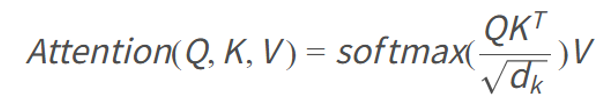

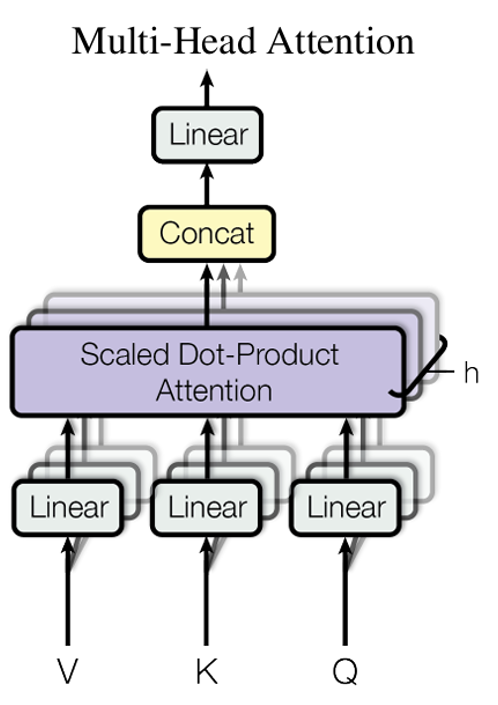

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, d_model, d_ff):
    super().__init__()
    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)
    self.relu = nn.ReLU()

  def forward(self, X):
    X = self.relu(self.linear1(X))
    X = self.linear2(X)
    return X

In [ ]:
d_ff = 2048

multihead_attn = MultiHeadAttention(d_model, num_heads)
ff_network = FeedForward(d_model, d_ff)
input_sequence = torch.randn(5, max_len, d_model)
attention_output = multihead_attn(input_sequence, input_sequence, input_sequence)
output_ff = ff_network(attention_output)
print("input_sequence: ", input_sequence.shape)
print("attention_output: ", attention_output.shape)
print("output_ff: ", output_ff.shape)

input_sequence:  torch.Size([5, 100, 512])
attention_output:  torch.Size([5, 100, 512])
output_ff:  torch.Size([5, 100, 512])


In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout):
    super().__init__()
    self.self_attention = MultiHeadAttention(d_model, num_heads)
    self.ff = FeedForward(d_model, d_ff)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, X, mask):
    attention_output = self.self_attention(X, X, X, mask)
    attention_output = self.dropout(attention_output)
    # X += attention_output (absoluate NO!!!)
    X = X + attention_output
    X = self.norm1(X)
    ff_output = self.ff(X)
    ff_output = self.dropout(ff_output)
    X = X + ff_output
    X = self.norm2(X)
    return X

In [ ]:
encoder_layer = EncoderLayer(d_model, num_heads, d_ff, 0.1)
input_sequence = torch.randn(5, max_len, d_model)
encoder_output = encoder_layer(input_sequence, None)
print("encoder_output shape: ", encoder_output.shape)

encoder_output shape:  torch.Size([5, 100, 512])


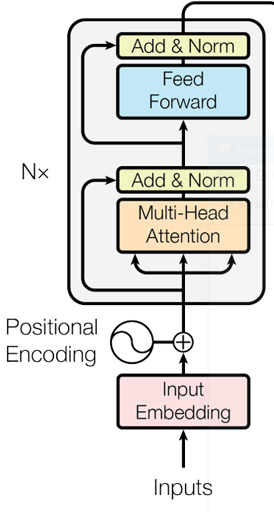

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout):
    super().__init__()
    self.masked_self_attn = MultiHeadAttention(d_model, num_heads)
    self.en_de_attention = MultiHeadAttention(d_model, num_heads)
    self.ff = FeedForward(d_model, d_ff)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.norm3 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, X, encoder_output, src_mask, tg_mask):
    # masked self attention
    self_attention_output = self.masked_self_attn(X, X, X, tg_mask)
    self_attention_output = self.dropout(self_attention_output)
    X = X + self_attention_output
    X = self.norm1(X)

    # encoder-decoder self attention
    en_de_attn_output = self.en_de_attention(
        X, encoder_output, encoder_output, src_mask
    )
    en_de_attn_output = self.dropout(en_de_attn_output)
    X = X + en_de_attn_output
    X = self.norm2(X)

    # FeedForward
    ff_output = self.ff(X)
    ff_output = self.dropout(ff_output)
    X = X + ff_output
    X = self.norm3(X)
    return X

In [ ]:
batch_size = 1
dropout = 0.1

decoder_layer = DecoderLayer(d_model, num_heads, d_ff, dropout)
src_mask = torch.rand(batch_size, max_len, max_len) > 0.5
tg_mask = torch.tril(torch.ones(max_len, max_len)).unsqueeze(0) == 0
output = decoder_layer(input_sequence, encoder_output, src_mask, tg_mask)
print("output shape: ", output.shape)

output shape:  torch.Size([5, 100, 512])


In [ ]:
src_mask

tensor([[[False,  True, False,  ..., False,  True, False],
         [False, False, False,  ..., False,  True, False],
         [ True, False, False,  ..., False, False, False],
         ...,
         [ True, False, False,  ..., False, False,  True],
         [ True,  True, False,  ..., False,  True,  True],
         [ True, False,  True,  ..., False, False, False]]])

In [ ]:
# Lower triangular mask
tg_mask

tensor([[[False,  True,  True,  ...,  True,  True,  True],
         [False, False,  True,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         ...,
         [False, False, False,  ..., False,  True,  True],
         [False, False, False,  ..., False, False,  True],
         [False, False, False,  ..., False, False, False]]])

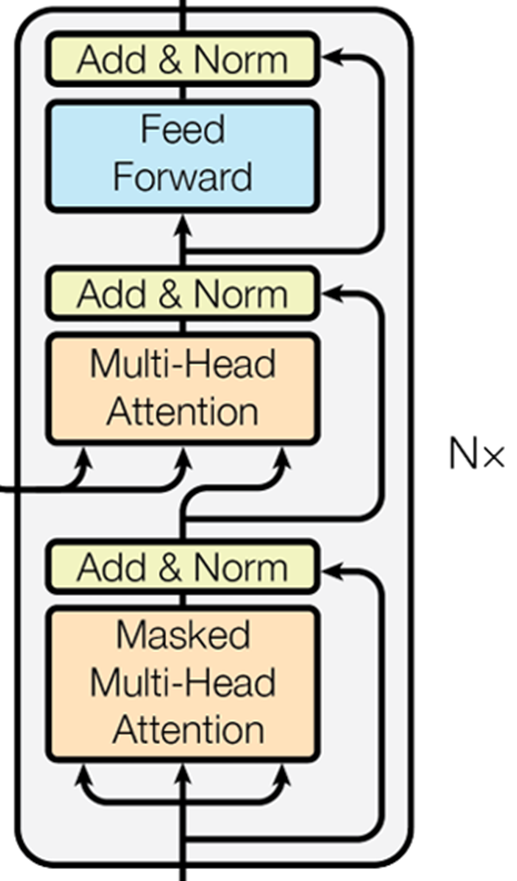

In [ ]:
class Transformer(nn.Module):
  def __init__(
      self, src_vocab_size, tg_vocab_size, d_model,
      num_heads, num_layers, d_ff, max_len, dropout
  ):
    super().__init__()
    # define the embedding layer of the encoder and decoder
    self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
    self.decoder_embedding = nn.Embedding(tg_vocab_size, d_model)
    self.positional_encoding = PositionalEncoding(d_model, max_len)
    self.encoder_block = nn.ModuleList([
        EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
    ])
    self.decoder_block = nn.ModuleList([
        DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
    ])
    self.linear = nn.Linear(d_model, tg_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def generate_mask(self, src, tg):
    scr_mask = (src != 0).unsqueeze(1).unsqueeze(2)
    tg_mask = (tg != 0).unsqueeze(1).unsqueeze(3)
    seq_length = tg.size(1)
    nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
    tg_mask = tg_mask & nopeak_mask
    return scr_mask, tg_mask

  def forward(self, src, tg):
    src_mask, tg_mask = self.generate_mask(src, tg)
    # Encoder inputting
    encoder_embedding = self.encoder_embedding(src)
    en_positional_encoding = self.positional_encoding(encoder_embedding)
    src_embedded = self.dropout(en_positional_encoding)
    # Decoder inputting
    decoder_embedding = self.decoder_embedding(tg)
    de_positional_encoding = self.positional_encoding(decoder_embedding)
    tg_embedded = self.dropout(de_positional_encoding)

    enc_output = src_embedded
    for enc_layer in self.encoder_block:
      enc_output = enc_layer(enc_output, src_mask)
    dec_output = tg_embedded
    for dec_layer in self.decoder_block:
      dec_output = dec_layer(dec_output, enc_output, src_mask, tg_mask)
    output = self.linear(dec_output)
    return output

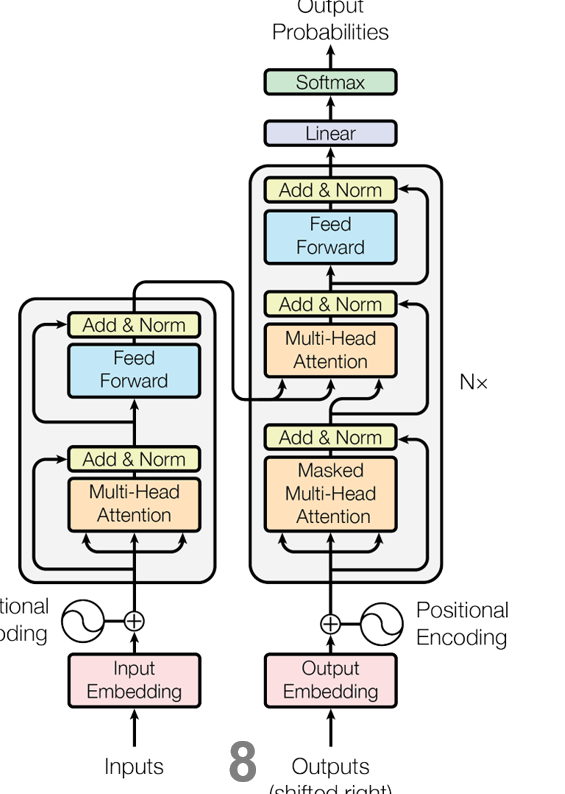

In [ ]:
src_vocab_size = 5000
tg_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_len = 100
dropout = 0.1

In [ ]:
transformer = Transformer(
    src_vocab_size, tg_vocab_size, d_model, num_heads, num_layers, d_ff, max_len, dropout
)

# generate random data
src_data = torch.randint(1, src_vocab_size, (5, max_len))
tg_data = torch.randint(1, tg_vocab_size, (5, max_len))
transformer(src_data, tg_data[:, :-1]).shape

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()
for epoch in range(10):
  optimizer.zero_grad()
  output = transformer(src_data, tg_data[:, :-1])
  loss = criterion(
      output.contiguous().view(-1, tg_vocab_size),
      tg_data[:, 1:].contiguous().view(-1)
  )
  loss.backward()
  optimizer.step()
  print(f"Iteration {epoch+1}: Loss: {loss.item():.4f}")

Iteration 1: Loss: 8.0249
Iteration 2: Loss: 7.4948
Iteration 3: Loss: 7.0097
Iteration 4: Loss: 6.5667
Iteration 5: Loss: 7.1392
Iteration 6: Loss: 6.3099
Iteration 7: Loss: 6.2608
Iteration 8: Loss: 6.2111
Iteration 9: Loss: 6.1616
Iteration 10: Loss: 6.1363


In [ ]:
src_data = torch.randint(1, src_vocab_size, (5, max_len))
tg_data = torch.randint(1, tg_vocab_size, (5, max_len))

transformer.eval()
with torch.no_grad():
  output = transformer(src_data, tg_data[:, :-1])
  loss = criterion(
      output.contiguous().view(-1, tg_vocab_size),
      tg_data[:, 1:].contiguous().view(-1)
  )
  print(f"Evaluation Loss: {loss.item():.4f}")

Evaluation Loss: 11.8382
